In [7]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
from pylab import rcParams
import healpy as hp
from tqdm import *
from astropy import units as u
from scipy.ndimage.filters import gaussian_filter

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
pylab.rcParams.update(params)
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
# plots_dir = "/Users/smsharma/Desktop/LensPower_Offline/plots/"

data_dir = "/Users/smsharma/QuasarSims/"

/Users/smsharma/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/smsharma/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/smsharma/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/smsharma/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


In [8]:
max_sep = 20
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150, alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

Simulating 1208 subhalos between 7.0 and 10.0


In [9]:
sim.analysis_pipeline(get_sample=True)

  0%|          | 0/1208 [00:00<?, ?it/s]

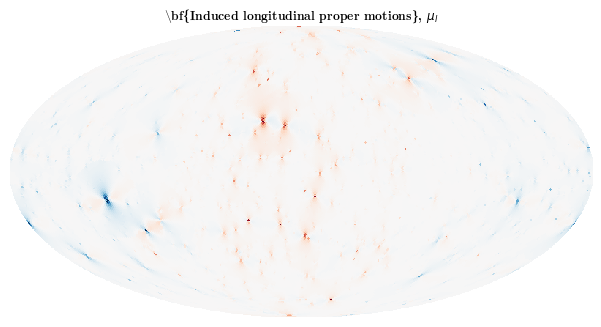

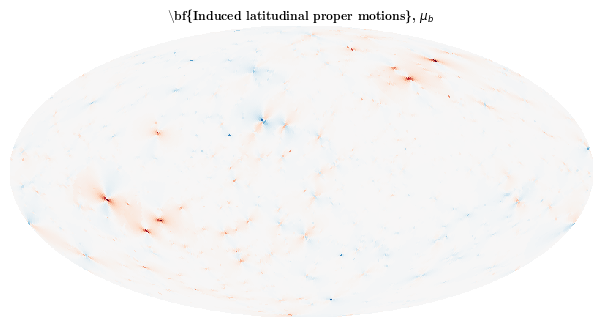

In [10]:
max_mu = 8e-4 / 0.6e-4
cmap = cmaps.RdBu_r
cmap.set_under('w')

hp.mollview(1e6 * sim.mu_qsrs[:,0] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced longitudinal proper motions}, $\mu_l$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)
hp.mollview(1e6 * sim.mu_qsrs[:,1] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced latitudinal proper motions}, $\mu_b$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)

In [200]:
import sys
sys.path.append("../")

from models.embedding import SphericalGraphCNN

In [201]:
nside_list = [64, 32, 16, 8, 4, 2]

In [202]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, mask_ring = False)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])


In [204]:
import torch
in_map = torch.Tensor((sim.mu_qsrs.reshape((1, -1, 2))))
# in_map = torch.Tensor((sim.mu_qsrs[:, 0].reshape((1, -1, 1))))
in_map.shape

torch.Size([1, 49152, 2])

In [205]:
log_mean = torch.log(torch.mean(in_map, axis=1))
log_std = torch.log(torch.var(in_map, axis=1).sqrt())

log_mean = log_mean.reshape((1, -1, 2))
log_std = log_std.reshape((1, -1, 2))

data_map = torch.cat([in_map, log_mean, log_std], axis=1)
data_map.shape

torch.Size([1, 49154, 2])

In [208]:
sg = SphericalGraphCNN(nside_list, indexes_list, n_aux_var=2, in_ch=2)

In [211]:
sg(data_map).shape

torch.Size([1, 128])